# 序列模型

在了解了序列统计工具后，让我们在实践中尝试一下！

## 训练
首先，我们生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据，时间步为 $1, 2, \ldots, 1000$。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

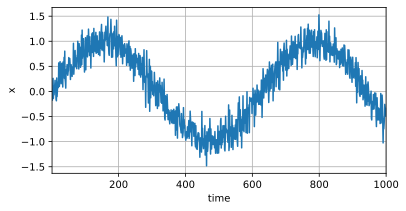

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的“特征－标签”（feature-label）对。
基于嵌入维度 $\tau$，我们将数据映射为数据对 $y_t = x_t$ 和 $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。
这比我们提供的数据样本少了 $\tau$ 个，因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项，另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

这里，我们使用一个相当简单模型，一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，开始训练模型了。

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.087445
epoch 2, loss: 0.062879
epoch 3, loss: 0.055792
epoch 4, loss: 0.052797
epoch 5, loss: 0.051408


## 预测

首先是检查模型预测下一个时间步的能力，也就是单步预测（one-step-ahead prediction）。


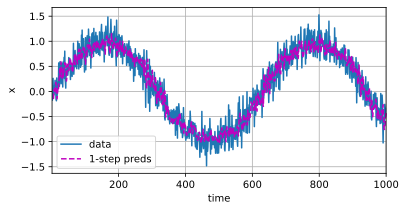

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。即使这些预测的时间步超过了$600+4$（`n_train + tau`），其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到 $604$，我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到 $x_t$ 的观测序列，其在时间步 $t+k$处的预测输出$\hat{x}_{t+k}$ 称为 $k$ 步预测（$k$-step-ahead-prediction）。
由于我们的观察已经到了 $x_{604}$，它的 $k$ 步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。
让我们看看效果如何。


In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

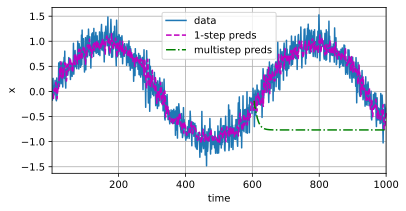

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想，经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
这是由于错误的累积，假设在步骤 $1$ 之后，我们积累了一些错误 $\epsilon_1 = \bar\epsilon$。于是，步骤 $2$ 的输入被扰动了 $\epsilon_1$，结果积累的误差是依照次序的 $\epsilon_2 = \bar\epsilon + c \epsilon_1$， 其中 $c$ 为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，但超过这一点，精度就会迅速下降。

基于 $k = 1, 4, 16, 64$，通过对整个序列预测的计算，让我们更仔细地看一下 $k$ 步预测的困难。

In [10]:
max_steps = 64

In [11]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

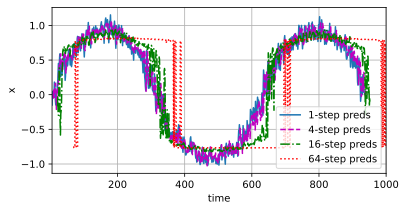

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。